In [1]:
import numpy as np
import os
import gc
import random
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset

import transformers
from transformers import T5ForConditionalGeneration, T5Tokenizer
from nltk.translate.bleu_score import sentence_bleu

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!ls

test.csv  train.csv


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
display(train_df)

,source_url,author,name,poetry,metre
0,https://rupoem.ru/baratynskij/svoi-stishki-tos...,Евгений Баратынский,Эпиграмма (Свои стишки Тощев-пиит...),свои стишки тощев-пиит\nпокроем пушкина кроит\...,iambos
1,https://rupoem.ru/bryusov/molodoj-moryak-vsele...,Валерий Брюсов,Хвала Человеку,молодой моряк вселенной\nмира древний дровосек...,choreios
2,https://rupoem.ru/xodasevich/metel-metel-v.aspx,Владислав Ходасевич,На ходу,застывшая рука\nкак ты близка\nи всё-таки бред...,iambos
3,https://rupoem.ru/berggolc/esche-redaktor-kniz...,Ольга Берггольц,Еще редактор книжки не листает...,еще редактор книжки не листает\nс унылой и зна...,iambos
4,https://rupoem.ru/gippius/meshaetsya-slivaetsy...,Зинаида Гиппиус,"Мешается, сливается...",мешается сливается\nдействительность и сон\nвс...,iambos
...,...,...,...,...,...
9797,https://rupoem.ru/tixonov/flag-perepolnennyj-o...,Николай Тихонов,Советский флаг,флаг переполненный огнем\nцветущий как заря\nи...,iambos
9798,https://rupoem.ru/dementev/my-na-zemle.aspx,Андрей Дементьев,Мы на земле живем нелепо!..,мы на земле живем нелепо\nи суетливо\nпотому\n...,iambos
9799,https://rupoem.ru/vinokurov/ob-istine-i.aspx,Евгений Винокуров,Ложь,об истине и не мечтая\nя жил среди родни и спл...,iambos
9800,https://rupoem.ru/matveeva/podsolnux-sobstvenn...,Новелла Матвеева,Подсолнух,подсолнух еще не исчерпан\nироническое из крит...,iambos


In [5]:
lyric_to_try = train_df['poetry'][23]
print(lyric_to_try)

над этой темною толпой
непробужденного народа
взойдешь ли ты когда свобода
блеснет ли луч твой золотой
блеснет твой луч и оживит
и сон разгонит и туманы
но старые гнилые раны
рубцы насилий и обид
растленье душ и пустота
что гложет ум и в сердце ноет-
кто их излечит кто прикроет
ты риза чистая христа



In [6]:
MODEL_NAME = 'cointegrated/rut5-base-multitask'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model.cuda()
model.eval()

def run_t5(text, beams=5, grams=4, do_sample=False):
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 1.7)
    out = model.generate(**x, num_beams=beams, encoder_no_repeat_ngram_size=grams, max_length = max_size, do_sample = do_sample)
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [7]:
print(run_t5(lyric_to_try[0:2]))
print(run_t5(lyric_to_try[2:4]))

Она
Да.


In [8]:
class PoetryDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.tokenizer = tokenizer
        self.chunk_sz = 4
        self.input_sz = 2
        self.in_tokens = []
        self.out_tokens = []
        
        for poetry in tqdm(data['poetry']):
            text = poetry.strip().split('\n')
            for chunk_start in range(0, len(text) - self.chunk_sz, self.input_sz):
                in_chunk = text[chunk_start:(chunk_start + self.input_sz)]
                out_chunk = text[(chunk_start + self.input_sz):(chunk_start + (2 * self.input_sz))]
                self.in_tokens.append(self.get_tokens(in_chunk))
                self.out_tokens.append(self.get_tokens(out_chunk))
    
    def get_tokens(self, chunk):
        reversed_0 = ' '.join(chunk[0].strip().split(' ')[::-1])
        reversed_1 = ' '.join(chunk[1].strip().split(' ')[::-1])
        tokens = ''.join(self.tokenizer.tokenize(reversed_0)) + '.' + ''.join(self.tokenizer.tokenize(reversed_1))
        return tokens
    
    def __getitem__(self, index):
        x = self.in_tokens[index]
        y = self.out_tokens[index]
        return x, y
        
    def __len__(self) -> int:
        return len(self.in_tokens)

continue training from the privious step

In [9]:
model.load_state_dict(torch.load('../input/last-model/last_model_epoch_16.pth'))
model.train()
model.cuda()

T5ForConditionalGeneration(
  (shared): Embedding(30000, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(30000, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [10]:
train = PoetryDataset(train_df, tokenizer)
train_loader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle=True)

  0%|          | 0/9802 [00:00<?, ?it/s]

In [11]:
optimizer = torch.optim.Adam(params=[p for p in model.parameters() if p.requires_grad], lr=1e-5)

In [12]:
torch.cuda.empty_cache()
gc.collect()

45

In [13]:
def draw_losses(loss_list):
    clear_output(wait=True)
    fig = plt.figure(figsize = (8, 5))
    plt.plot(loss_list)
    plt.grid()
    plt.show()

In [14]:
start_epoch = 17
def train(model, tokenizer, train_loader, optimizer, num_epoch = 2, nosiness = 200):
    nosiness = 200
    losses_list = []
    losses = []
    epoch_loss_list = []
    for epoch in range(start_epoch, num_epoch):
        for i, batch in enumerate(tqdm(train_loader)):
            x, y = batch
            x_tokenized = tokenizer(x, return_tensors='pt', padding=True).to(model.device)
            y_tokenized = tokenizer(y, return_tensors='pt', padding=True).to(model.device)
            y_tokenized.input_ids[y_tokenized.input_ids==0] = -100
            
            loss = model(
                input_ids=x_tokenized.input_ids,
                attention_mask=x_tokenized.attention_mask,
                labels=y_tokenized.input_ids,
                decoder_attention_mask=y_tokenized.attention_mask,
                return_dict=True
            ).loss
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            if i % nosiness == 0 and i != 0:
                losses_list.append(torch.mean(torch.tensor(losses[:-nosiness])))
                draw_losses(losses_list)
                
        epoch_loss_list.append(torch.mean(torch.tensor(losses)))
        losses = []
        draw_losses(epoch_loss_list)
        print('ended epoch {}, mean_loss = {:.3f}'.format(epoch, epoch_loss_list[-1]))
        torch.save(model.state_dict(), 'last_model_epoch.pth')
        
        if epoch % 5 == 0:
            torch.save(model.state_dict(), 'model_epoch_' + str(epoch) + '.pth')
            
    return model

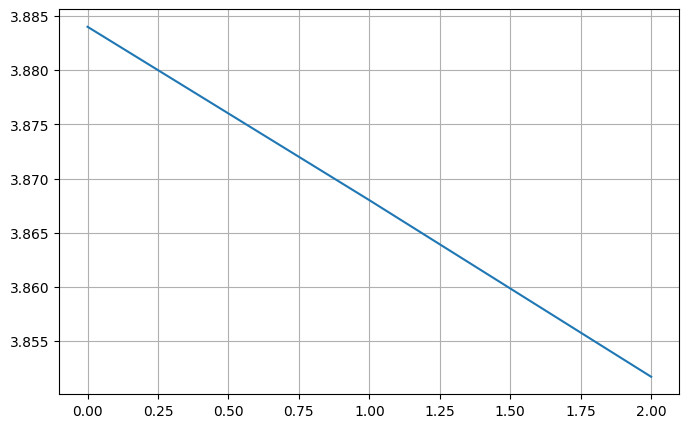

ended epoch 19, mean_loss = 3.852


In [15]:
res_model = train(model, tokenizer, train_loader, optimizer, num_epoch = 20)

In [16]:
def prepeare_input(text, tokenizer):
    strings = text.split('\n')
    reversed_in = ''
    for i, s in enumerate(strings):
        reversed_in += ' '.join(s.strip().split(' ')[::-1])
        if i != len(strings) - 1:
            reversed_in += '.'
            
    input = tokenizer(reversed_in, return_tensors='pt', padding=True).to(model.device)
    return input

def decode_res(out_tokens, tokenizer):
    # print('out_tokens = ', out_tokens)
    decoded = tokenizer.decode(out_tokens, skip_special_tokens=True)
    decoded_strings = decoded.split('.')
    reversed_out = ''
    for i, s in enumerate(decoded_strings):
        reversed_out += ' '.join(s.strip().split(' ')[::-1])
        if i != len(decoded_strings) - 1:
            reversed_out += '\n'            
    return reversed_out

def make_poetry(model, text, tokenizer, beams=5, grams=4, do_sample=False):
    input = prepeare_input(text, tokenizer).to(model.device)
    out = model.generate(**input, num_beams=beams, encoder_no_repeat_ngram_size=grams, do_sample=do_sample)
    return decode_res(out[0], tokenizer)

In [17]:
print(make_poetry(res_model, 'белеет мой парус такой одинокий\nна фоне стальных кораблей', tokenizer))

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


и только слышу я глубокий и одинокий



In [18]:
print(make_poetry(res_model, 'но я не плачу и не рыдаю\nна все вопросы я открыто отвечаю', tokenizer))

и ничего я не знаю и не знаю
не знаю
